# AirBnB-Zillow Data Challenge 2018
#By: Valliappan Chithambaram

In [1]:
import pandas as pd
import numpy as np
import os
import csv
import bokeh as bk
from bokeh.plotting import figure,show,output_notebook,output_file
from bokeh.models import NumeralTickFormatter,HoverTool
#from bokeh.layouts import layout, widgetbox
#from bokeh.models import ColumnDataSource, Div
#from bokeh.models.widgets import Slider, Select, TextInput
#from bokeh.io import curdoc
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',500)

# Function to import data

In [2]:
def import_datasets():
    a=1
    import_df=pd.DataFrame
    while (a!=0):
        import_filepath = str(raw_input("Enter CSV filepath:"))
        if os.path.isfile(import_filepath) or import_filepath.startswith('http'):
            comp=None
            if 'gz' in import_filepath.split('\\')[-1]:comp='gzip'
            if 'zip' in import_filepath.split('\\')[-1]:comp='zip'
            import_df= pd.read_csv(import_filepath,compression=comp,low_memory=False)
            a=0
        else: 
            print "Please enter a valid file path. Try again? (y/n)"
            quit_loop=str(raw_input())
            if quit_loop == 'n' or quit_loop == 'N':
                a=0
            else:
                a=1
    return import_df

# Function to join datasets

In [3]:
#Function to merge 2 Datasets. Parameters: DataFrame1,DataFrame2
def merge_datasets(left_df,right_df,join_how,join_col_list):
    abnb_col_list=list(abnb_df)
    zllw_col_list=list(zllw_df)
    #common_list=list(['zipcode'])
    merged_df=pd.DataFrame
    if join_col_list == []:
        print "Join columns not provided,Merging two datasets by index"
        merged_df=left_df.merge(right_df, how=join_how, left_index=True,right_index=True)
    else:
        print "Merging two datasets by join columns"
        merged_df = abnb_df.merge(zllw_df, how = join_how, on = join_col_list)#common_list)
    if not merged_df.empty:
        print "Merged successfully."
        output_merged_file=str(raw_input("Do you want to save merged dataset into a csv file (y/n):")).lower()
        if output_merged_file == 'y':
            merge_filepath=str(raw_input("Enter filname with full path:"))
            #r'C:\Users\eee634\Ganesh\airbnb-zillow-data-challenge-master\merged_dataset.csv'
            merged_df.to_csv(merge_filepath,sep=',')
            print "Merged file is saved at location %s"%(merge_filepath)
    else:
        print "Merge Unsuccessful or Merged dataset empty"
    return merged_df 

# Scatter Plot function

In [30]:
def scatter_plot(plot_df,title_text,format_y="0",format_x="0"):
    y=[plot_df.columns.get_values()[0]]
    x=[plot_df.columns.get_values()[1]]
    idx=plot_df.index.name
    hover = HoverTool(
        tooltips=[
            (str(y[0]), "@"+str(y[0])),
            (str(x[0]), "@"+str(x[0])),
            (idx,"@"+idx)
        ],
    )
    r=(plot_df[x[0]].max()-plot_df[x[0]].min())/100.00*0.4
    dvp_plot=figure(plot_width=800,plot_height=400,tools=[hover])
    dvp_plot.title.text= title_text
    dvp_plot.title.text_font_size="20px"
    dvp_plot.title.align='center'
    dvp_plot.yaxis[0].axis_label = str(y[0]) #'Demand (median booked days/quarter)'
    dvp_plot.xaxis[0].axis_label = str(x[0]) #'Revenue (Price per night)'
    xaxis=plot_df[x[0]]
    yaxis=plot_df[y[0]]
    dvp_plot.text(x=xaxis,y=yaxis,text=plot_df.index.values.tolist(),text_color="black",text_align="center",text_font_style="bold",text_font_size="8pt",y_offset=-4)
    dvp_plot.circle(x=str(x[0]),y=str(y[0]),source=plot_df,radius=r,size=10,color="red",alpha=3)
    dvp_plot.xaxis[0].formatter = NumeralTickFormatter(format=format_x)
    dvp_plot.yaxis[0].formatter = NumeralTickFormatter(format=format_y)
    #output_file('chart.html')
    output_notebook()
    return dvp_plot

### Import datasets into Pandas Dataframe for analysis

In [5]:
abnb_df=import_datasets()
zllw_df=import_datasets()

Enter CSV filepath:C:\\Users\\Shashi\\CV_Datachallenge_Jul-2018\\listings.csv.gz
Enter CSV filepath:C:\\Users\\Shashi\\airbnb-zillow-data-challenge-master\\Zip_Zhvi_2bedroom.csv.zip
Please enter a valid file path. Try again? (y/n)
y
Enter CSV filepath:C:\\Users\\Shashi\\airbnb-zillow-data-challenge-master\\Zip_Zhvi_2bedroom.csv
Please enter a valid file path. Try again? (y/n)
y
Enter CSV filepath:C:\\Users\\Shashi\\CV_Datachallenge_Jul-2018\\Zip_Zhvi_2bedroom.csv.zip


C:\\Users\\Shashi\\CV_Datachallenge_Jul-2018\\listings.csv.gz
C:\\Users\\Shashi\\CV_Datachallenge_Jul-2018\\Zip_Zhvi_2bedroom.csv.zip

# Data Cleansing and Data profiling

### Zillow Dataset
Data check revealed that Zipcode is name as RegionName, Also there were property prices for many cities outside of NYC.And there were faily long history (about 2 decades) of monthly snapshot prices. For our analysis we do not need property prices for that long. Our assumption is that the real estate company is looking to  investment in near future, hence a more recent price index would be sufficient. However in order to study how the pricing is fluctuating historically, we will set a 5 year historical limit and calculate various median price indices.

Standardizing Field names, filtering out unwanted data

In [6]:
zllw_df.rename(columns={'RegionName':'zipcode'},inplace=True)
zillow_col_list=zllw_df.columns
zllw_NY_df=zllw_df.loc[(zllw_df['City']=='New York')]
zllw_cleansed=pd.DataFrame()
zllw_cleansed[zillow_col_list[1:7]]=pd.DataFrame(zllw_NY_df[zillow_col_list[1:7]])
#most recent month available is considered Current Price
zllw_cleansed['Current_price']=pd.DataFrame(zllw_NY_df[zillow_col_list[len(zillow_col_list)-1]])
#median of latest 12 months
zllw_cleansed['1year_median_price']=zllw_NY_df[zillow_col_list[len(zillow_col_list)-12:]].median(axis=1)
#median of latest 36 months (3 years)
zllw_cleansed['3year_median_price']=zllw_NY_df[zillow_col_list[len(zillow_col_list)-36:]].median(axis=1)
#median of latest 60 months (5 years)
zllw_cleansed['5year_median_price']=zllw_NY_df[zillow_col_list[len(zillow_col_list)-60:]].median(axis=1)
zllw_cleansed.set_index('zipcode',inplace=True)
zllw_cleansed['Current_price']=zllw_cleansed['Current_price'].astype('float64')

In [7]:
zllw_cleansed.corr()

,SizeRank,Current_price,1year_median_price,3year_median_price,5year_median_price
SizeRank,1.000000,-0.419865,-0.407125,-0.403493,-0.391285
Current_price,-0.419865,1.000000,0.996425,0.993990,0.990999
1year_median_price,-0.407125,0.996425,1.000000,0.999035,0.996839
3year_median_price,-0.403493,0.993990,0.999035,1.000000,0.998196
5year_median_price,-0.391285,0.990999,0.996839,0.998196,1.000000


SizeRank is a numerical number indicating the rank. it does not provide the net difference in population size between 2 zipcodes or the population percentage. so we cannot use that for estimating the Population density or Zipcode area.

In [8]:
zllw_prices=zllw_cleansed[zllw_cleansed.columns[len(zllw_cleansed.columns)-4:]]
zllw_prices.columns=['current_cost','1year_median_cost','3year_median_cost','5year_median_cost']

zillow data has time series data about median price index for over 2 decades. For our study historical prices of the property would not have much influence on budget.We are assuming that the company wants to invest in short term rental in near future (<1year). so a more stable price estimate would be 1year_median_price. Moreover Current price and historical median prices are in the same relative trend as shown in the below table. Also long historical median price tends to be slightly lower than current price, hence we will use 1year_median_price for our analysis

In [9]:
zllw_prices.sort_values(['current_cost'])

,current_cost,1year_median_cost,3year_median_cost,5year_median_cost
zipcode,,,,
10303,327700.0,298900.0,263700.0,250850.0
10304,328300.0,296850.0,267350.0,247250.0
10306,352900.0,324150.0,304000.0,282600.0
10312,355000.0,331950.0,315950.0,304150.0
10314,357300.0,330700.0,303250.0,286500.0
11434,382300.0,357950.0,316850.0,286050.0
10309,390500.0,359200.0,333500.0,319350.0
10308,409500.0,371150.0,336000.0,320500.0
10305,425100.0,386600.0,339000.0,315850.0


### Airbnb Dataset
Initial inspection of Airbnb dataset revealed that there are around 40000 listings across various Zipcodes in NYcity area and a coupleo f zipcodes in New Jersey. Various property types from single bed, to mansion, including boats and lofts are in the listings.Also the properties listed had bedrooms from 1 to 8. As per the requirement we will filer out unwanted listings outside of NY City and properties that do not have 2 bedrooms for rent.
Secondly the dataset has various freeform/unstructured data like Property URL, host notes, comments etc. those do not add value for our analysis. Hence filtering out only columns related to Revenue, Availability, Customer Score, Property type, Neighborhood etc by Zipcode , State and City.

In [10]:
abnb_req_cols=['zipcode','price','weekly_price','monthly_price','security_deposit','cleaning_fee','availability_365','availability_30','availability_60',
               'availability_90','review_scores_rating','number_of_reviews','review_scores_location','reviews_per_month','city','property_type','neighbourhood_cleansed']
               #'host_response_time','host_response_rate','host_acceptance_rate','host_listings_count','host_total_listings_count','neighbourhood_cleansed'
abnb_cleansed=pd.DataFrame(abnb_df[abnb_req_cols]).loc[(abnb_df['bedrooms']==2)&(abnb_df['state']=='NY')]

Standardizing field names and datatypes

In [11]:
abnb_cleansed['price']=pd.to_numeric((abnb_cleansed['price'].replace('[\$,]','', regex=True)), errors='coerce')
abnb_cleansed['weekly_price']=pd.to_numeric((abnb_cleansed['weekly_price'].replace('[\$,]','', regex=True)), errors='coerce')
abnb_cleansed['monthly_price']=pd.to_numeric((abnb_cleansed['monthly_price'].replace('[\$,]','', regex=True)), errors='coerce')
abnb_cleansed['security_deposit']=pd.to_numeric((abnb_cleansed['security_deposit'].replace('[\$,]','', regex=True)), errors='coerce')
abnb_cleansed['cleaning_fee']=pd.to_numeric((abnb_cleansed['cleaning_fee'].replace('[\$,]','', regex=True)), errors='coerce')
abnb_cleansed['zipcode']=pd.to_numeric((abnb_cleansed['zipcode'].str.strip().str[:5]),errors='coerce').fillna(0).astype('int64')
abnb_cleansed.set_index('zipcode',inplace=True)

## Merging Datasets and combined analysis 

In [12]:
temp_merge=merge_datasets(abnb_cleansed,zllw_prices,'left',[])

Join columns not provided,Merging two datasets by index
Merged successfully.
Do you want to save merged dataset into a csv file (y/n):n


Quick check on match quality revealed that nearly 60% of the listings from Airbnb data is not matched with Zillow data since Zillow dataset does not have all zipcodes in NYC.Some of the Zipcodes in 'Williamsburg' and 'East village' neighborhood have more than 100 listings.Cost data is critical to determine profitability,so unfortunately all unmatched zipcodes must be left out from Return of Investment analysis. This is a significant population to be left out. 
At this point we will split our analysis into 2 phases. in Phase 1 we will consider Zipcodes with Cost data(matched with Zillow data) and in Phase 2 only revenue analysis and see how other factors influence pricing. That could reveal interesting trends within Airbnb Listings.

In [13]:
#abnb_df.loc[abnb_df.bedrooms==2].groupby(['city','state','property_type','zipcode']).size()
#abnb_cleansed.groupby('property_type').agg({'property_type':np.size,'price':np.max})
#abnb_cleansed=abnb_cleansed[abnb_cleansed.property_type!='Boat']

#abnb_cleansed.groupby(['zipcode','city']).size()
#temp_merge=abnb_cleansed.merge(zllw_prices,how='left',left_index=True,right_index=True)
#Check how many rows in Airbnb file had a match in Zillow data
print "Number of rows matched : %d" %(temp_merge['1year_median_cost'].notnull().sum())
print "Number of rows unmatched : %d" %(temp_merge['1year_median_cost'].isnull().sum())
x=pd.DataFrame(temp_merge.loc[temp_merge['1year_median_cost'].isnull()].groupby(['zipcode','city','neighbourhood_cleansed','property_type']).size())
x.columns=['row_count']
print "No of Zipcodes with atleast 10 properties that are not found in Zillow data: %d" %(x[x.row_count>9].count())
print "\nzipcode, city and neghborhoods with unmatched zillow data ordered by most properties"
x.row_count.sort_values(ascending=False)

Number of rows matched : 1239
Number of rows unmatched : 3654
No of Zipcodes with atleast 10 properties that are not found in Zillow data: 73

zipcode, city and neghborhoods with unmatched zillow data ordered by most properties


zipcode  city                   neighbourhood_cleansed     property_type     
11211    Brooklyn               Williamsburg               Apartment             249
10009    New York               East Village               Apartment             147
10002    New York               Lower East Side            Apartment             115
11222    Brooklyn               Greenpoint                 Apartment             107
10019    New York               Hell's Kitchen             Apartment              97
11221    Brooklyn               Bedford-Stuyvesant         Apartment              88
11249    Brooklyn               Williamsburg               Apartment              80
11216    Brooklyn               Bedford-Stuyvesant         Apartment              78
10027    New York               Harlem                     Apartment              73
11233    Brooklyn               Bedford-Stuyvesant         Apartment              68
10024    New York               Upper West Side            Apartment    

5 factors that influence investment strategy: Demand, popularity, customer_value,Revenue/Cost = ROI
An Ideal/profitable investment would be in a Zipcode that has 
High Demand
Medium - high popularity
High customer value
High ROI

The Occupancy rate is used for estimating demand. Unlike noted in the excercise we will not assume 70% occupancy, because by doing so will rate all the zipcodes at same performance, then high priced zipcodes will have advantage over other low price segment Zipcodes. Hence we will use the availability data in Airbnb dataset as occupancy rate.

Airbnb Dataset has atleast 4 availability metric at different time period 30 days, 60 days, 90days and 365 days. A quick data check reveals that availability data upto 90 days are realistic and in most of the cases 365 day availability has same value as 90 days availability. Since we are setting our analysis period for a quarter, 90 day availability metric would be an appropriate estimation.

In [14]:
abnb_cleansed.loc[abnb_cleansed['availability_365']<abnb_cleansed['availability_90']]

,price,weekly_price,monthly_price,security_deposit,cleaning_fee,availability_365,availability_30,availability_60,availability_90,review_scores_rating,number_of_reviews,review_scores_location,reviews_per_month,city,property_type,neighbourhood_cleansed
zipcode,,,,,,,,,,,,,,,,


### Standardizing and deriving new metrics to suit our analysis needs:
The following attributes are derived from Airbnb data:

Revenue: Median price of a property for daily rental at Zipcode level. It is Sum of Daily rental price and cleaning fee if any.Even though cleaning fee is technically not a revenue it goes against variable cost and since some properties collect cleaning fee and some do not. A fee collected is additional income that would offset expense.Hence we are considering the fees as part of Revenue

Demand: Median demad rate by Zipcode.It is percentage  of number of booked days over 90 days. This gives as the demand rate averaged at Zipcode level. 100% demand means the property is booked for all 90 days, in other words availability is 0.

Agg_score: Median score of all customer rating given based on accuracy, cleanliness, check-in, communication, location, and value averaged at Zipcode level.

Location_rating: Median score of all customer ratings on Neighborhood.

Popularity: Total number of listings by Zipcode.

ROI: Return of Investment: It is the percentage of revenue earned in a quarter against cost of the property.This indicates how many years are required to recover the entire investment made. This rate standardizes revenue and cost at different rate into one scale for easy comparison between Zipcodes. Higher the RoI, better the performnce of the Zipcode. 

In [15]:
abnb=pd.DataFrame(abnb_cleansed.price.fillna(0)+abnb_cleansed.cleaning_fee.fillna(0)).groupby('zipcode').median()
abnb.columns=['revenue']
abnb['demand']=abnb_cleansed.availability_90.groupby('zipcode').median()
abnb['agg_score']=abnb_cleansed.review_scores_rating.groupby('zipcode').median()
abnb['total_reviews']=abnb_cleansed.number_of_reviews.groupby('zipcode').sum()
abnb['location_rating']=abnb_cleansed.review_scores_location.groupby('zipcode').median()                   
abnb['popularity']=abnb_cleansed.price.groupby('zipcode').count()
abnb['demand']=(90-abnb.demand)/90.00
merge_df=merge_datasets(abnb,zllw_prices,'left',[]).copy()

Join columns not provided,Merging two datasets by index
Merged successfully.
Do you want to save merged dataset into a csv file (y/n):n


In [16]:
merge_df.drop(0,inplace=True)

In [17]:
print "No. of Zipcodes matched with Zillow:%d" %merge_df['1year_median_cost'].notnull().sum()
print "No. of Zipcodes unmatched with Zillow:%d" %merge_df['1year_median_cost'].isnull().sum()
#excluding unmatched Zip codes from first round of analysis
final_df= merge_df.loc[merge_df['1year_median_cost'].notnull()].copy()

No. of Zipcodes matched with Zillow:22
No. of Zipcodes unmatched with Zillow:126


In [18]:
#in order to plot the chart effectively the cost value is scaled to 1/100000the value.
final_df['1year_median_cost_in_K']=final_df['1year_median_cost']/100000.0
final_df['roi']=final_df.revenue*final_df.demand*90.0/final_df['1year_median_cost']
final_df['roi_est']=final_df.revenue*90.0/final_df['1year_median_cost']

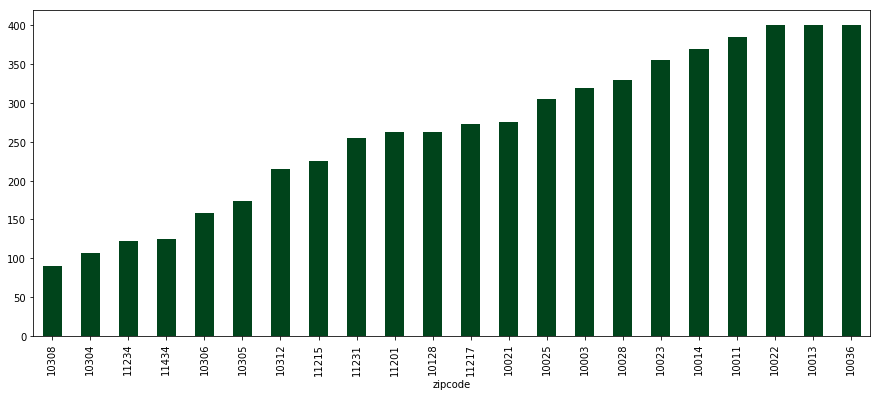

In [19]:
plot_df=pd.DataFrame(final_df.revenue)
plot_df.columns=['revenue']
plot_df.sort_values('revenue',inplace=True)
plot_df['revenue'].plot(kind='bar',cmap='Greens_r',figsize=(15,6))
plt.title=('Median Revenue by Zipcode')
plt.show()                    

From above chart we can see that Zipcodes 10036, 10013,10022 are in the top earning \$400 per night.

In [20]:
plot1_df=final_df[['revenue','1year_median_cost_in_K']].copy()
plot1_df.sort_values(['revenue','1year_median_cost_in_K'],inplace=True)

In [21]:
from bokeh.models import HoverTool,BoxAnnotation
hover = HoverTool(
        tooltips=[
            ("Revenue", "@revenue"),
            ("Cost", "@1year_median_cost_in_K"),
            ("Zipcode","@zipcode")
        ]
    )
rvc_plot=figure(plot_width=900,plot_height=400,tools=[hover])
rvc_plot.title.text='Cost by Revenue'
rvc_plot.title.text_font_size="20px"
rvc_plot.title.align='center'
rvc_plot.yaxis[0].axis_label = 'Median Property Cost (in 100,000$)'
rvc_plot.xaxis[0].axis_label = 'Revenue(Price per night)'
y=plot1_df['1year_median_cost_in_K']
x=plot1_df['revenue']
rvc_plot.text(x=x,y=y,text=plot1_df.index.values.tolist(),text_color="black",text_align="center",text_font_style="bold",text_font_size="8pt",y_offset=-4)
rvc_plot.line(y='1year_median_cost_in_K',x='revenue',source=plot1_df,line_width=2.5,color="green",alpha=1)
rvc_plot.circle(y='1year_median_cost_in_K',x='revenue',source=plot1_df,radius=1.5,color="yellow",alpha=3)
rvc_plot.xaxis[0].formatter = NumeralTickFormatter(format="($ 0,0)")
rvc_plot.yaxis[0].formatter = NumeralTickFormatter(format="(0,0)")
output_file('Cost_to_Revenue_line_chart.html')
output_notebook()
show(rvc_plot)

Loading BokehJS ...

From above Chart we can see as the revenue increases the cost increases too, except for Zipcodes: 10306, 10305 and 10312. Those could be anamoly or hidden gems with relative low cost and high revenue. The true measure of profitability is when Revenue is normalized for price that is Revenue/Cost = Return of Investment.

Another trend to notice here, as pricing increases from \$200 to \$400, the cost increases exponentially at the rate of 2x.  

From investment purposes the zipcode that offers highest Return of Investment(ROI) would be the best choice, since for ROI to go up either Cost must come down or Revenue must go up. From Zillow data we can infer that the median price of the property remains pretty stable over a long period. So only the Revenue can move up.

In order to calculate Revenue we have to determine the rate of occupancy. A good way to estimate revenue is to see the current listings and determine how they perform at set periods. The availability metric in Airbnb data can be used for this. as we have established in data quality check the availability data for future 90 days are reliable. So using that to estimate the performance of the listings by quarter

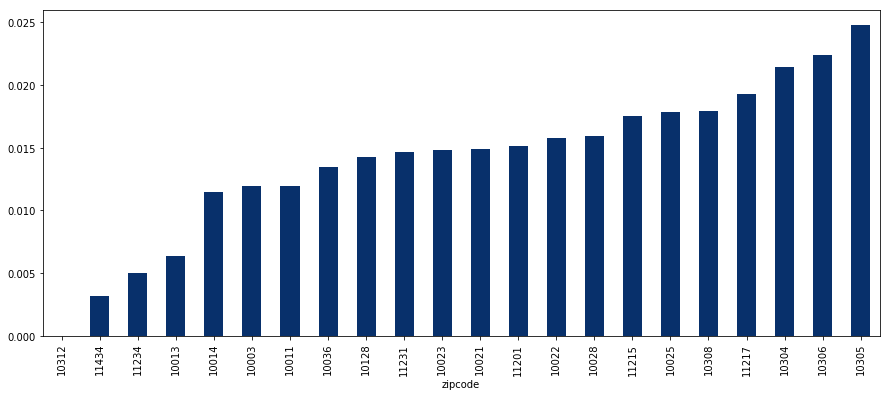

In [22]:
plot_df=pd.DataFrame(final_df.roi)
plot_df.columns=['roi']
plot_df.sort_values('roi',inplace=True)
plot_df['roi'].plot(kind='bar',cmap='Blues_r',figsize=(15,6))
plt.title=('Median Return of Investment by Zipcode')
plt.show() 

As we can see from the chart above Zipcodes 10305,10304 and 10306 are high yielding zipcodes, but we have to understand that, this high RoI is because of very low median property prices in those zipcodes.So we need to consider other factors that inlfluence short term rental business Revenue such as Cost, Demand, Popularity of the Location,Customer Affinity.

So let us see how is Revenue influenced by those other factors.

In [29]:
p=scatter_plot(final_df[['demand','revenue']],'Demand by Revenue','(0%)','(0)')
show(p)

Loading BokehJS ...

From above chart we can see Demand is high for properties below \$100 per night or \$225-\$385 per night.Lot of Zipcodes clustered above 80% demand indicates that  \$250 - \$350 is the best pricing band. 

Assuming no impacts from external factors (like seasonality, attractions etc) investing in new properties would increase supply decrease demand.Hence zipcode with demand above 80% is ideal for investment and the demand comes down it could still be around 70% occupancy rate that we are assuming/aiming for. Based on this Zipcodes 10308,11215,10201,11217,10028 etc are top contenders.

In [24]:
#xdf=final_df[['demand','revenue']].loc[final_df.demand > 20]
p=scatter_plot(final_df[['popularity','revenue']],'Popularity by Revenue','(0,0)','(0)')
show(p)

Loading BokehJS ...

Now we have to see how many listings that are currently in the zipcodes, because investing in new properties would add to supply and hence impacts demand and revenue. 

Total number of listings in a Zipcode is a blended indicator for Supply and Popularity of neighborhood/zipcode. That means supply is relative to Zipcode for example around 80 listings in zipcode 11217 generates 100% demand whereas the same number of listings in zipcode 10013 generates 60% demand. This can be attributed to price. Since the pricing is high in 10013 it is not generating that much demand. Hence the number of listings is an indicator of both supply and popularity of the neighborhood. 

Looking at the chart above high demand zipcodes have varying supply. For example 10308 has 80% demand, but it has only 1 listing. Adding another property will bring down the demand to 40% .Investing in zipcode 11217 is better since the demand is very high(97%),adding more supply would bring down the demand only a little.

On the other hand zipcode 10013 has similar supply but medium demand.Adding more supply would push the demand low and hence price/revenue. With high cost coupled with low demand the ROI is going to go down. 

Hence investing in medium to high demand with high supply/popularity zipcodes:11215,11217,10025,1003,10014 etc are top contenders.

In [31]:
#xdf=final_df[['demand','revenue']].loc[final_df.demand > 20]
p=scatter_plot(final_df[['demand','agg_score']],'Customer affinity vs Demand','(0,0%)','(0)')
show(p)

Loading BokehJS ...

Overall Customer Affinity chart follows similar trend as Demand chart with the exception of Zipcode 10304. Almost all zipcodes have median review score of above 90. Interestingly zipcode 10308 has a high score eventhough there is only one property listed there. it could probably a skewed metric and also since the pricing is very low customers are happy with the services they get in that price range.

Similar check on Location score indicates that almost all the zipcodes are scored at 100%. so Customer affinity does not play an active role in investment, However we can use this rating to prioritize zipcode. Afterall happy customer brings more business.

Three zipcodes that emerged profitable 10305,10306,10312 in Cost to Revenue chart are not in high demand though. If there is no high demand then supply is high eventhough they have only few listings each, investing in those zipcodes will increase supply and there by reduce demand and profitability, unless the cost is so low that even with low demand they could emerge profitable.

Filtering the dataset for Medium to High demand, High popularity and sorting by Customer review score and Return of Investment gives us top 7 Zipcodes ideal for investment.

In [32]:
#sort dataset based on above findings: Medium-High demand, high popularity, high RoI
ydf=pd.DataFrame(final_df.loc[(final_df['demand'] >= 0.6) & (final_df['popularity']>75)])
ydf.sort_values(['popularity','agg_score','roi'],ascending=False,inplace=True)
ydf[['demand','popularity','agg_score','revenue','1year_median_cost','roi']]


,demand,popularity,agg_score,revenue,1year_median_cost,roi
zipcode,,,,,,
11215,0.888889,141,96.0,225.0,1028600.0,0.017500
10003,0.805556,134,95.0,319.5,1942550.0,0.011924
10025,0.888889,112,94.5,305.0,1365200.0,0.017873
10036,0.650000,108,93.0,400.0,1741000.0,0.013441
10011,0.811111,102,95.0,385.0,2347150.0,0.011974
10014,0.844444,95,94.0,370.0,2456900.0,0.011445
11217,0.961111,86,97.0,272.5,1220500.0,0.019313


# Phase2: Trend Analysis on Zipcodes without Cost

In [33]:
nocost_df=merge_df.loc[merge_df['1year_median_cost'].isnull()].copy()

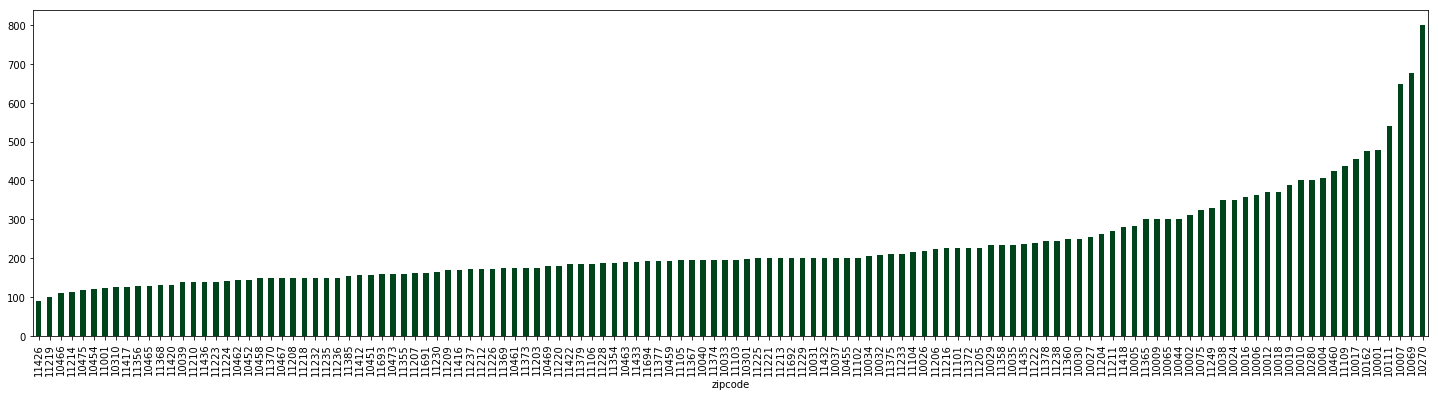

In [34]:
plot_df=pd.DataFrame(nocost_df.revenue)
plot_df.columns=['revenue']
plot_df.sort_values('revenue',inplace=True)
plot_df['revenue'].plot(kind='bar',cmap='Greens_r',figsize=(25,6))
plt.title=('Median Revenue by Zipcode')
plt.show()  

In [35]:
p=scatter_plot(nocost_df[['demand','revenue']],'Demand by Revenue (Zipcodes without cost)','(0%)','(0)')
show(p)

Loading BokehJS ...

This Demand by Revenue chart for Zipcodes without cost is following similar trend, but the appealing pricing band is widened a bit from \$150 to \$450. Zipcodes with revenue outside that range have overall lesser demand.

Also this chart reveals there are more than 50% of Zipcodes with revenue band \$100 to \$200. Properties with median cost of \$500,000 in these Zipcodes would be highly profitable for this price band. Due to unavailability of property cost , we cannot conclusively determine best performing Zipcodes.

In [36]:
#xdf=final_df[['demand','revenue']].loc[final_df.demand > 20]
p=scatter_plot(nocost_df[['popularity','revenue']],'Popularity by Revenue (Zipcodes without Cost)','(0,0)','(0)')
show(p)

Loading BokehJS ...

This Chart reveals an interesting trend. Eventhough \$100 to \$200 is a dense price band, more than 90% of those zipcodes have very few listings (in single digits <10). It could mean that the demand is very high because of less supply and adding new listings in those zipcodes would bring down the demand drastically. It also indicates that \$100 - \$200 is an economically sensitive price band. slight increase in price would drastically bring down the demand.

Again price band \$200 - \$300 perform better here, consistent with Zipcodes that we know their median property cost. One other interesting thing to note here is Zipcode 11211 has relatively large number of listings and yet it has more than 80% demand rate. If the median property cost in this zipcode is comparable to other Zipcodes in that range, it could be one of the potential Zipcodes for investment

In [37]:
#xdf=final_df[['demand','revenue']].loc[final_df.demand > 20]
p=scatter_plot(nocost_df[['agg_score','revenue']],'Customer affinity vs Demand (Zipcodes without Cost)','(0)','(0)')
show(p)

Loading BokehJS ...

It is clear from above chart that customers like listings with lower price band.An indication for economically sensitive customers. According to NYC government planning Hotel Market Analysis (Ref: https://www1.nyc.gov/assets/planning/download/pdf/plans-studies/m1-hotel-text/nyc-hotel-market-analysis.pdf, Page#38) the average price per night is consistenly above \$250 in past 6 years, So Airbnb listings turns out economical for short term renters and our chart indicates the same with high customer affinity to that price band. The current Airbnb listings in this price band enjoys huge demand and hence could provide high Return of Investment provided the median property cost in those zipcodes are in the range of \$500,000 - \$750,000 (based on our study earlier with zipcodes with cost data).

Overall conclusion is that due to non-availability of cost data for all these Zipcodes, it is not possible to conclusively determine the profitability. However based on the trend revealed through series of charts above, the \$100 - \$200 price band is one of the promising segments to consider for investment.

# Conclusion

Based on details analysis looking at various factors influencing profitability and analyzing through 100+ zipcodes with 40000+ listings, we can conclusively shortlist the following 
###### 7 top performing Zipcodes in their order of prederence:
    11215
    10003
    10025
    10036
    10011
    10014
    11217

The above mentioned Zipcodes have an average occupancy rate higher than 80% and have high customer affinity. The median cost of property in these zipcodes ranges from  \$900,000 to \$2.3 Million there by estimated to yeild around a quarterly RoI of 1.25% to 2.5%

In addition to these, based on our findings from analyzing Zipcodes that did not have cost information (Refer to addendum analysis), it is indicating that there is a high demand and high review ratings for listings at \$100 - \$200 range. This price range is below the average daily rate in NYC hotel market which is \$250 and above per  https://www1.nyc.gov/assets/planning/download/pdf/plans-studies/m1-hotel-text/nyc-hotel-market-analysis.pdf, Page#38. and is appealing for short term renters. Infact it is one the edges that Airbnb listings have over traditional Hotel businesses. Zipcodes 10304, 10305 and 10308 have high demand and high ROI. Median Property cost in those Zipcodes are very low (less than \$500,000) and hence high ROI. These Zipcodes are ideal for low cost investment strategy.

# Executive Summary

Objective:
--------------

The objective of this analysis is to identify ideal Zipcodes in NY city area for real estate company to invest in two bedroom properties for short term rentals. Two publicly available datasets, Airbnb listing data (for Revenue) and Zillow Property (for cost) are used to conduct this study.

An ideal Zipcode for investment would yield high revenue with low cost. In short term rental business there are Fixed costs and Variable costs. Property cost makes up major of Fixed costs.There are other costs suchs as wages to employees, utilities etc.And there are Variable costs such as housekeeping, food, groceries, maintanance etc. Those information are not available to us right now. so we are making few assumptions along the way to arrive at conclusive findings.

Assumptions:
--------------------
1. The analysis is conducted assuming current period as May-Jun-2017 since the datasets are timestamped for that window and we do not have have timeseries data for Airbnb for later periods.
2. We assume the estimation study conducted per May-Jun-2017 would be relevant for future period as well,since the time value of money discount rate is 0%. Also the ratio of income vs expenses should remain fairly same for near future.
3. We assume the occupancy rate of the listings for 90 day period has no outside influences such as promotions, seasonal attractions etc.
4. Due to non-availability of time-series data. we assumed a study of listings for their performance for one quarter would provide insight on profitability.
5. Since the listing price per night provides the highest revenue, for this study we assume all the listings are rented for daily rental so that the estimated revenue is highest possible for a given listing. Moreover the monthly and weekly prices are closely related to Daily price.
6. We assumed that variable costs and minor fixed costs associated with running a short term rental to be similar accross all zipcodes. meaning in RoI calculations the only cost considered is the property purchase price and all other cost offset is considered to be uniform accross all properties. moreover other costs unaccounted are very nominal when compared to property cost.  

Findings:
-------------
An Ideal/profitable investment would be in a Zipcode that has high demand, most popular, high customer affinity and high Return of Investment (ROI). In order to determine ideal Zipcodes we could either build out an estimation model that can predicts profitability OR study the performance of current listings over a fixed period of time and determine high performing Zipcodes. Due to unavailability of time-series data for Airbnb listings and information on external factors that influence demand and price, we used the 2nd approach for this analysis, that is performace of current listings over a fixed period of time. Based on quality check of datasets it is determined a 3 month (quarterly) performance of listings would give us insight on profitability.

Major factors that influence investment strategy are: Demand,Supply,Location Popularity,Customer_value,Revenue & Cost.

a. Demand influences Revenue and the number of days a property is booked indicates demand.

b.Adding a property for rental in a zipcode would add to supply there by reducing demand (assuming no other external factors influencing demand). so if a zipcode had 10 listings,adding one more would increase the supply by 10%, whereas zipcode with 100 listings would have 1% increase in supply. Hence Total number of listings in a Zipcode is a blended indicator for Supply and Popularity of neighborhood/zipcode. higher the nummber of listing , lower the influx of supply when new properties are added for rental. 
c. Customer affinity drives demand.Happy customer brings repeat business, Moreover high review rating attracts new customers.

After detailed analysis we are concluding that the ideal price range for listings is \$250 to \$350 per night with an average occupancy rate higher than 80% and have high customer affinity. The median cost of property in these zipcodes ranges from  \$900,000 to \$2.3 Million there by estimated to yeild around a quarterly RoI of 1.25% to 2.5%. The list of Zipcodes ideal for investment in the order of preference:
Zipcodes in first preference:
---------------------------------------
    11215
    10003
    10025
    10036
    10011
    10014
    11217
    
Additionally the following Zipcodes with low cost low revenue high returns can be considered, in the order of priority based on their current demand level, number of listings:
Zipcodes in second preference:
--------------------------------------------
    10308
    10305
    10304

Next Steps:
----------------
1.As next steps we currently have only a snapshot of revenue data and historical cost data. We can augment this with more input data related to zipcode population index, seasonality, attractions etc and further refine the analysis.

2.The cost information from Zillow data matched for less than 40% of zipcodes. There were more than 50 Zipcodes without median property cost and hence could not be included into this analysis for conclusive finding. The property cost data can be expanded to include all zip codes 

3.The most appealing price band for NY rentals is \$250 - \$350. This puts Airbnb listings in direct competition with hotel market. Our understanding is that the airbnb listings are doing well because they do not have overhead costs involved in traditonal hotel business. However an extensive analysis considering those factors could reveal new patterns.

4.Airbnb listings are very popular in \$100 - \$200 price band. This economical segment could trun out to be most profitable since the properties in such zipcodes tend to cost less. Also overall trend of rental price vs property cost shows that the property cost increases at a rate of 2x - 3x times that of rental price increase.

5.This analysis is performed entirely within Airbnb market, We need to include data from traditional hotel market and other compitetive business to realistically gauge the performance.


# Thanks
Valliappan Chithambaram (C.V)